# Predict log EC50s of Dual-Agonists Peptide using Pretrained Protein Language Model

The example in this paper is derived from the following paper:

Puszkarska, A.M., Taddese, B., Revell, J. et al. Machine learning designs new GCGR/GLP-1R dual agonists with enhanced biological potency. Nat. Chem. (2024)

Here is the link to its original github repository [PeptideModels](https://github.com/amp91/PeptideModels)

This paper aims to design dual-agonists peptides targeting human GCG and GLP-1 receptors. The loss function of the original model contains the MSE loss of peptide-GCGR log EC50 and the MSE loss of peptide-GLP-1R log EC50, for the purpose of multi-task learning.

We have trained 1D convolutional neural networks in chapter 6 on this dataset. In this notebook, we will download a pretrained protein language model (PLM) from `huggingface`, and use the pretrained embeddings to perform few-shot learning.

This notebook refers to [Language Model Embeddings Transfer Learning for Downstream Task](https://github.com/Graylab/DL4Proteins-notebooks/blob/main/notebooks/WS05_LanguageModelEmbeddingsTransferLearningForDownstreamTask.ipynb).

In [ ]:
!pip install numpy pandas matplotlib torch wget seaborn scikit-learn transformers

## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Load Dataset

In [4]:
# download the pre-processed dataset from github
!python -m wget https://raw.githubusercontent.com/xuhuihuang/uwmadisonchem361/main/CNN_training_data.csv \
--output CNN_training_data.csv


Saved under CNN_training_data (1).csv


In [5]:
filename = "CNN_training_data.csv"
df = pd.read_csv(filename)
df

,pep_ID,EC50_T1,EC50_LOG_T1,EC50_T2,EC50_LOG_T2,Aligned_Sequence
0,seq_pep1,3.75,-11.43,563.00,-9.25,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE
1,seq_pep2,18.50,-10.73,552.00,-9.26,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE
2,seq_pep3,3.51,-11.45,252.00,-9.60,HSQGTFTSDYSKYLDSRRAEDFVQWLENT-
3,seq_pep4,50.50,-10.30,6.03,-11.22,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGG
4,seq_pep5,2.87,-11.54,238.00,-9.62,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG
...,...,...,...,...,...,...
120,seq_pep121,29000.00,-7.54,9.62,-11.02,HGEGTFTSDVSSYMERQSVDEFIAWLLKGR
121,seq_pep122,29400.00,-7.53,7.94,-11.10,HGEGTFTSDVSSYMESQLVDEFIAWLLKGR
122,seq_pep123,29500.00,-7.53,29500.00,-7.53,HGEGTFTSDVSSYMEPQSTDEFIAWLLKGR
123,seq_pep124,29200.00,-7.53,598.00,-9.22,HGEGTFTSDVSSYMDFQSLVEFLAWLLKGR


## Create PyTorch Dataset

Convert sequence to token ids.

**Very important note**: The amino acid encodings are different from those for 1D CNN, because we want to make the encoding consistent with the pretrained protein language models. We will replace the `seq2onehot` function with the ESM2 Tokenizer. The ESM2 pretrained models and tokernizers are available at [huggingface EMS](https://huggingface.co/docs/transformers/en/model_doc/esm).

In [6]:
from transformers import AutoTokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Number of tokens: {tokenizer.vocab_size}")
print("Vocabulary:", tokenizer.get_vocab())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of tokens: 33
Vocabulary: {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}


Example of encoding one peptide sequence:

In [7]:
seq = df.iloc[0]["Aligned_Sequence"]
print(f"Sequence: {seq}")

tokens = tokenizer.tokenize(seq)
print(f"Tokens: {tokens}")

token_ids = tokenizer(seq, max_length=30, \
    padding=False, truncation=False, return_tensors="pt")
print(f"Token IDs: {token_ids}")

Sequence: HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE
Tokens: ['H', 'S', 'Q', 'G', 'T', 'F', 'T', 'S', 'D', 'Y', 'S', 'K', 'Y', 'L', 'D', 'S', 'R', 'R', 'A', 'Q', 'D', 'F', 'V', 'Q', 'W', 'L', 'E', 'E', 'G', 'E']
Token IDs: {'input_ids': tensor([[ 0, 21,  8, 16,  6, 11, 18, 11,  8, 13, 19,  8, 15, 19,  4, 13,  8, 10,
         10,  5, 16, 13, 18,  7, 16, 22,  4,  9,  9,  6,  9,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


In [8]:
def encode_sequence(sequence):
    return tokenizer(sequence, padding=False, truncation=False, \
        return_tensors="pt")["input_ids"]

In [9]:
class PeptideDataset(Dataset):
    def __init__(self, df, encoder,
                 seq_col="Aligned_Sequence", target_cols=("EC50_LOG_T1", "EC50_LOG_T2")):
        self.df = df
        self.encoder = encoder
        self.seq_col = seq_col
        self.target_cols = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row[self.seq_col]
        indices = self.encoder(sequence)
        label = [row[col] for col in self.target_cols]
        return indices.reshape(-1), torch.tensor(label, dtype=float).reshape(-1)

## Split Dataset

In [10]:
from sklearn.model_selection import train_test_split

# training/validation dataset
data_size = df.shape[0]
test_ratio = 0.10
test_size = int(data_size*test_ratio)
train_indices, test_indices = train_test_split(range(data_size), test_size=test_size, shuffle=True)
print(f"Training size: {len(train_indices)}, test size: {len(test_indices)}")
train_df, test_df = df.iloc[train_indices], df.iloc[test_indices]

Training size: 113, test size: 12


In [11]:
# create dataloaders
batch_size = 10
encoder = encode_sequence
train_data = PeptideDataset(train_df, encoder=encoder)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, drop_last=False)
test_data = PeptideDataset(test_df, encoder=encoder)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, drop_last=False)

An example of the training data:

In [12]:
train_data[0]

(tensor([ 0, 21,  8, 16,  6, 11, 18, 11,  8, 13, 19,  8, 15, 19,  4, 13,  8, 10,
         10,  5,  9, 13, 18,  7, 16, 22,  4,  7,  5,  6,  6,  2]),
 tensor([-10.3000, -11.2200], dtype=torch.float64))

## Protein Language Model (PLM)

We will load pretrained ESM2 model from huggingface.

In [13]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_name)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
dummy_input = torch.zeros(1, 3).long()
output_dct = model(dummy_input)
print("Output dictionary keys:", output_dct.keys())
print("Last hidden state shape:", output_dct["last_hidden_state"].shape) # per residue
print("Pooler output shape:", output_dct["pooler_output"].shape) # per sequence

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 7511801
Output dictionary keys: odict_keys(['last_hidden_state', 'pooler_output'])
Last hidden state shape: torch.Size([1, 3, 320])
Pooler output shape: torch.Size([1, 320])


## Model Wrapper

We will add two regression head on top of the pretrained model for our downstream tasks.

In [14]:
import torch.nn as nn
class MultiHeadModel(nn.Module):

    def __init__(self, esm_name, encoder_frozen=True, dropout=0.3):
        super().__init__()
        # encode each sequence to a vector
        model = AutoModel.from_pretrained(esm_name)
        self.base_model = model
        self.encoder_frozen = encoder_frozen
        if self.encoder_frozen:
            for _, param in self.base_model.named_parameters():
                param.requires_grad = False

        ## calculate output dim of the base model
        self.dummy_input = torch.zeros(1, 1)
        self.flattened_size = self._calculate_flattened_size()

        self.fc = nn.Linear(in_features=self.flattened_size, out_features=64, bias=True)

        self.dropout = nn.Dropout(dropout)

        # fully connected layer for GCGR
        self.head_1 = nn.Linear(in_features=64, out_features=1, bias=True)

        # fully connected layer for GLP-1R
        self.head_2 = nn.Linear(in_features=64, out_features=1, bias=True)

    def _calculate_flattened_size(self):
        """Pass dummy data through the network to get the flattened size."""
        with torch.no_grad():
            input_seqs = self.dummy_input.long()
            base_out_dict = self.base_model(input_seqs)
            hidden_dim = base_out_dict["pooler_output"].shape[-1]
        return hidden_dim


    def forward(self, input_seqs):
        input_seqs = input_seqs.long()
        base_out_dict = self.base_model(input_seqs)

        # amino acid embeddings pooled to a sequence embedding
        base_out = base_out_dict["pooler_output"]
        base_out = self.fc(base_out)

        # two linear head
        out_1 = self.head_1(self.dropout(base_out))
        out_2 = self.head_2(self.dropout(base_out))

        return torch.cat([out_1, out_2], dim=1)

## Training Utils

In [15]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    losses = []
    model.train()
    for x, y_true in dataloader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        y_true = y_true.float()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y_true.squeeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().item())
    return losses


def val_one_epoch(model, criterion, dataloader):
    losses = []
    model.eval()
    with torch.no_grad():
        for x, y_true in dataloader:
            if device == "cuda":
                x, y_true = x.to(device), y_true.to(device)
            y_true = y_true.float()
            y_pred = model(x)
            loss = criterion(y_pred, y_true.squeeze(1))
            losses.append(loss.cpu().detach().item())
    return losses

In [16]:
# loss function: 0.5 GCGR MSE + 0.5 GLP-1R MSE
def multi_task_loss(y_pred, y_true):
    y1_pred, y1_true = y_pred[:, 0], y_true[:, 0]
    y2_pred, y2_true = y_pred[:, -1], y_true[:, -1]
    mse1 = nn.MSELoss()(y1_pred, y1_true)
    mse2 = nn.MSELoss()(y2_pred, y2_true)
    return 0.5 * mse1 + 0.5 * mse2

## Training

In [17]:
model = MultiHeadModel(esm_name=model_name, encoder_frozen=True, dropout=0.3)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


model = model.to(device)
model = model.float()
criterion = multi_task_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
n_epochs = 500

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters: 7532475


In [18]:
train_loss = []
val_loss = []

for epoch in range(n_epochs):
    losses = train_one_epoch(model, criterion, optimizer, train_loader)
    train_loss.append(np.mean(losses))
    losses = val_one_epoch(model, criterion, test_loader)
    val_loss.append(np.mean(losses))
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}")

Epoch: 0
Epoch: 20
Epoch: 40
Epoch: 60
Epoch: 80
Epoch: 100
Epoch: 120
Epoch: 140
Epoch: 160
Epoch: 180
Epoch: 200
Epoch: 220
Epoch: 240
Epoch: 260
Epoch: 280
Epoch: 300
Epoch: 320
Epoch: 340
Epoch: 360
Epoch: 380
Epoch: 400
Epoch: 420
Epoch: 440
Epoch: 460
Epoch: 480


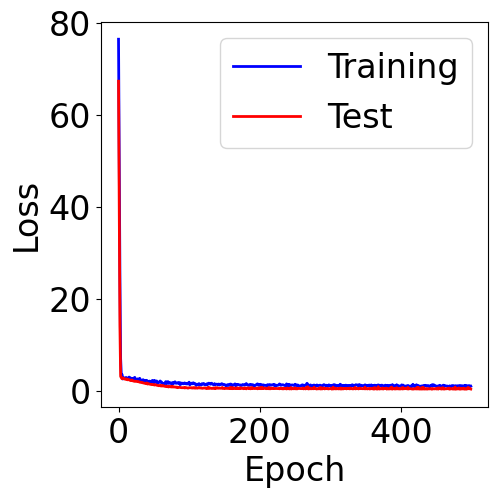

In [19]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(train_loss, c="blue", label="Training")
ax.plot(val_loss, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Evaluation metrics

In [20]:
truths = []
predictions = []
model.eval()
with torch.no_grad():
    for x,y in test_loader:
        if device == "cuda":
            x = x.to(device)
        x = x.float()

        y_pred = model(x)
        predictions.extend(y_pred.cpu().detach().numpy().tolist())

        y = y.squeeze(1).float().numpy().tolist()
        truths.extend(y)

### GCGR

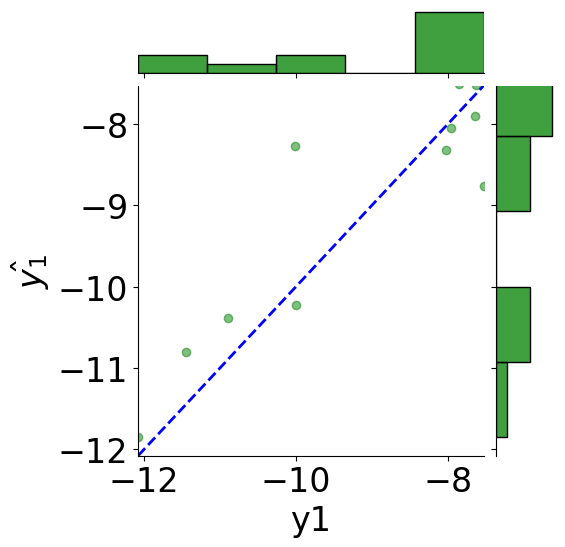

In [21]:
y1_true = [pair[0] for pair in truths]
y1_pred = [pair[0] for pair in predictions]
y2_true = [pair[1] for pair in truths]
y2_pred = [pair[1] for pair in predictions]
tmp_df = pd.DataFrame({"y1": y1_true, r"$\hat{y_1}$": y1_pred,
                       "y2": y2_true, r"$\hat{y_2}$": y2_pred})

# scatter plot
g = sns.JointGrid(x="y1", y=r"$\hat{y_1}$", data=tmp_df)
g = g.plot_joint(plt.scatter, c="green", alpha=0.5)

# line: y_pred = y
y_line = np.linspace(np.min(y1_true), np.max(y1_true), 200)
g.ax_joint.plot(y_line, y_line, color="blue", linestyle="--");

# histograms
g = g.plot_marginals(sns.histplot, data=df, color="green", kde=False)

g.ax_joint.set_xlim(np.min(y_line), np.max(y_line))
g.ax_joint.set_ylim(np.min(y_line), np.max(y_line))

plt.show()

In [22]:
print(f"MSE: {mean_squared_error(y1_true, y1_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y1_true, y1_pred):.2f}")

MSE: 0.51
Coefficient of determination: 0.81


### GLP-1R

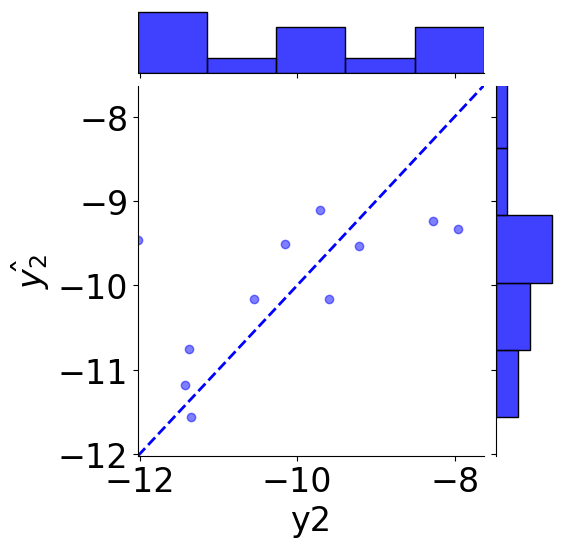

In [23]:
# scatter plot
g = sns.JointGrid(x="y2", y=r"$\hat{y_2}$", data=tmp_df)
g = g.plot_joint(plt.scatter, c="blue", alpha=0.5, label="GLP-1R")

# line: y_pred = y
y_line = np.linspace(np.min(y2_true), np.max(y2_true), 200)
g.ax_joint.plot(y_line, y_line, color="blue", linestyle="--");

# histograms
g = g.plot_marginals(sns.histplot, data=df, color="blue", kde=False)

g.ax_joint.set_xlim(np.min(y_line), np.max(y_line))
g.ax_joint.set_ylim(np.min(y_line), np.max(y_line))

plt.show()

In [24]:
print(f"MSE: {mean_squared_error(y2_true, y2_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y2_true, y2_pred):.2f}")

MSE: 0.93
Coefficient of determination: 0.53


## Cross Validation

Since the model performance variates on this small dataset for different splits. To thoroughly compare the ESM2 fine-tuning results with 1D CNN results, the following blocks are used to conduct a 6-fold cross validation.

In [25]:
from sklearn.model_selection import KFold

batch_size = 10
n_splits = 6
n_epochs = 600

# cross validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_indices = np.arange(df.shape[0])
criterion = multi_task_loss

In [26]:
def run_one_fold(train_df, test_df):
    encoder = encode_sequence
    train_data = PeptideDataset(train_df, encoder=encoder)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True, drop_last=False)
    test_data = PeptideDataset(test_df, encoder=encoder)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=False, drop_last=False)

    model = MultiHeadModel(esm_name=model_name, encoder_frozen=True, dropout=0.3)

    model = model.to(device)
    model = model.float()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    train_loss = []
    val_loss = []

    for epoch in range(n_epochs):
        losses = train_one_epoch(model, criterion, optimizer, train_loader)
        train_loss.append(np.mean(losses))
        losses = val_one_epoch(model, criterion, test_loader)
        val_loss.append(np.mean(losses))

    truths = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x,y in test_loader:
            if device == "cuda":
                x = x.to(device)
            x = x.float()
            y_pred = model(x)
            predictions.extend(y_pred.cpu().detach().numpy().tolist())

            y = y.squeeze(1).float().numpy().tolist()
            truths.extend(y)
    return truths, predictions

In [27]:
from sklearn.metrics import mean_squared_error
task_results = []

n_threads = n_splits

for train_index, test_index in kf.split(all_indices):
    train_df, test_df = df.iloc[train_indices], df.iloc[test_indices]
    truths, predictions = run_one_fold(train_df, test_df)

    y1_true = [pair[0] for pair in truths]
    y1_pred = [pair[0] for pair in predictions]
    y2_true = [pair[1] for pair in truths]
    y2_pred = [pair[1] for pair in predictions]

    mse1 = mean_squared_error(y1_true, y1_pred)
    mse2 = mean_squared_error(y2_true, y2_pred)
    task_results.append([mse1, mse2])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias'

In [28]:
avg_rmse = np.array(np.sqrt(task_results)).mean(axis=0)
std_rmse = np.array(np.sqrt(task_results)).std(axis=0)
print(f"RMSE: {avg_rmse}")
print(f"Std of RMSE: {std_rmse}")

RMSE: [0.80381721 1.06096567]
Std of RMSE: [0.17762752 0.03328328]


The following values are the average and stdev of RMSE for the 1D CNN model in chapter 6:

```
RMSE: [0.66108205 0.93760941]
Std of RMSE: [0.0422732  0.02007279]
```